In [0]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [0]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications.resnet50 import preprocess_input, ResNet50

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.getcwd()

'/content'

After Mounting Drive, Change Current Working Directory to 
**PATH** : '/content/drive/My Drive/Audio Classification with DL'

In [0]:
os.chdir('/content/drive/My Drive/Audio Classification with DL')

In [0]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [0]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [0]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis] #keep n_mels=128. other values are for experimenting

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [0]:
def split_convert(X, y):
    arr_spec, arr_genre = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in tqdm(zip(X, y),total=len(y),desc='Processing Audio Files'):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre, window=0.05) #keep window=0.05. Other values are for experimenting. 

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genre.extend(y)
        arr_spec.extend(specs)
    
    return np.array(arr_spec), to_categorical(arr_genre)

In [0]:
def read_data(src_dir, genres, song_samples,get_data='train'):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    if get_data=='train':
        for x,_ in genres.items():
            folder = src_dir+'/'+'train'+'/' + x
            for root, subdirs, files in os.walk(folder):
                for file in files:
                    file_name = folder + "/" + file

                    # Save the file name and the genre
                    arr_fn.append(file_name)
                    arr_genres.append(genres[x])
        
        # Split into small segments and convert to spectrogram
        X_train, y_train = split_convert(arr_fn, arr_genres)
        return X_train, y_train
    
    elif get_data=='test':
        folder = src_dir+'/'+'test'
        for root, subdirs, files in os.walk(folder):
            for idx,file in enumerate(files):
                file_name = folder + "/" + file
                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(idx//10)
    
        X_test, y_test = split_convert(arr_fn, arr_genres)
        return X_test, y_test
    else:
        #print('Specify "test" or "train"')
        return None,None

In [0]:
# Parameters
gtzan_dir = 'genres'
song_samples = 660000
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

# Read the data
#X_train, y_train = read_data(gtzan_dir, genres, song_samples,get_data='train')
X_test, y_test = read_data(gtzan_dir, genres, song_samples,get_data='test')

Processing Audio Files: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


In [0]:
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_test.shape

(3900, 128, 129, 1)

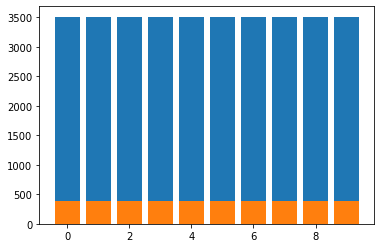

In [0]:
 # Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# GTZAN Melspectrogram Generator

In [0]:
from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=2)
                cols = np.random.randint(signal.shape[0], size=3)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

# Custom CNN (Melspectrogram version)

In [0]:
def conv_block(x, n_filters,filter_size=(3, 3), pool_size=(2, 2),stride=(1, 1)):
    x = Conv2D(n_filters, filter_size, strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=stride)(x)
    x = Dropout(0.4)(x)
    return x

In [0]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16,stride=(2,2))
    x = conv_block(x, 32,filter_size=(3,3),stride=(2,2))
    x = conv_block(x, 64, stride=(2,2))
    x = conv_block(x, 128,filter_size=(3,3),stride=(2,2))
    x = conv_block(x, 256,stride=(2,2))

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [0]:
model = create_model(X_train[0].shape, 10)

In [0]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 129, 1)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 129, 16)      160       
_________________________________________________________________
activation_22 (Activation)   (None, 128, 129, 16)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_23 (Activation)   (None, 64, 64, 32)        0   

### Loss function

In [0]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [0]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.97,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-10
)

In [0]:
# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [0]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=500,
    verbose=1,
    callbacks=[reduceLROnPlat])

Epoch 1/500
275/275 [==============================] - 6s 20ms/step - loss: 0.7529 - acc: 0.7633 - val_loss: 0.9451 - val_acc: 0.7369
Epoch 2/500
275/275 [==============================] - 6s 20ms/step - loss: 0.7607 - acc: 0.7579 - val_loss: 0.9708 - val_acc: 0.7213
Epoch 3/500
275/275 [==============================] - 5s 20ms/step - loss: 0.7639 - acc: 0.7597 - val_loss: 1.0101 - val_acc: 0.6935
Epoch 4/500
 28/275 [==>...........................] - ETA: 2s - loss: 1.0329 - acc: 0.7015
Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.8421612152887974e-05.
275/275 [==============================] - 6s 20ms/step - loss: 0.7579 - acc: 0.7640 - val_loss: 0.9848 - val_acc: 0.7198
Epoch 5/500
275/275 [==============================] - 5s 20ms/step - loss: 0.7657 - acc: 0.7601 - val_loss: 0.9972 - val_acc: 0.7097
Epoch 6/500
275/275 [==============================] - 6s 20ms/step - loss: 0.7625 - acc: 0.7543 - val_loss: 0.9268 - val_acc: 0.7283
Epoch 7/500
275/275 [==============

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.960 and val_acc = 0.691


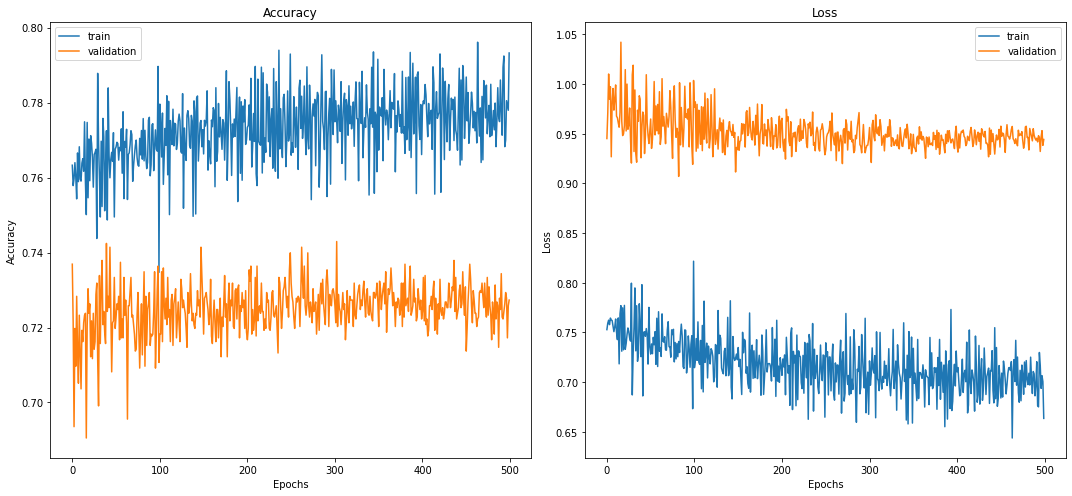

In [0]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


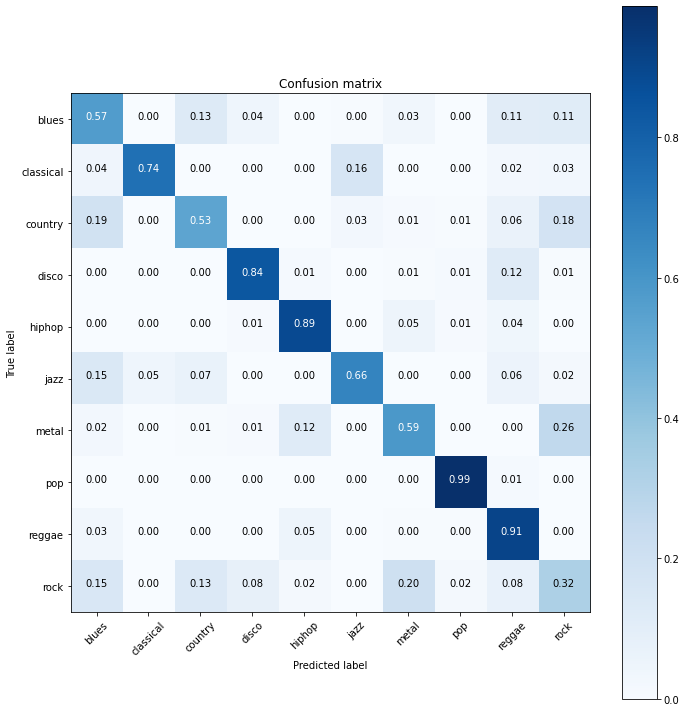

In [0]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

## Majority Vote

In [0]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [0]:
preds = model.predict(X_test, batch_size=128, verbose=0)

In [0]:
# Each sound was divided into 39 segments in our custom function
scores_songs = np.split(np.argmax(preds, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]

In [0]:
# Same analysis for split
label = np.split(np.argmax(y_test, axis=1), 300)
label = [majority_vote(l) for l in label]

In [0]:
from sklearn.metrics import accuracy_score

print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))

majority voting system (acc) = 0.730


Compared to the classical approach, we are winning now!


## Save the model

In [0]:
# Save the model
model.save('custom_cnn_2d.h5')